<table align="left">
  <td>
    <a href="https://is.gd/M5qGmU" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

# Applied Machine Learning Techniques to Breast Cancer Recurrence Classification

## Abstract



Diego R. Páez Ardila - 2120653


**Updated version: 20/04/2023**


# Methodology

1. **General Pre-Processing (GPP)**: The dataset is studied to identify missing data, analyze the correlation between the attributes and the target class, observe if there is an imbalance in the target class and identify if it is necessary to apply regularization to the data.

    After the analysis of the data, the following actions were taken:
    
    1. **Remove "Sex" attribute**: The number of men record (4) is not significant to be considered in the analysis. If only men records are removed the attribute will have only one value (Women).

    2. **Standardize all continuous variables**: The continuous variables are standardized to have a mean of 0 and a standard deviation of 1.

    3. **Categorical attributes with int values**: The categorical attributes with int values stay as they are.

    4. **Correlation between attributes**: Winter Hypoxia Score and Ragnum Hypoxia Score are highly correlated with Buffa Hypoxia Score are (0.84 and 0.72). The attribute Buffa Hypoxia Score is removed from the dataset.

    5. **Target Class**: The target class is unbalanced and has 3 classes related to the recurrence of breast cancer. Where class 3 is related to the absence of recurrence and classes 1 and 2 are related to the time when the recurrence occurred. In this stage no action is taken to balance the target class.

2. **Experiments**: Four experiments (E-1 to E-4) were defined to evaluate the performance of different machine learning models in breast cancer recurrence classification.

    1. **E-1**: Training of Logistic Regression (LR), Naive Bayes (NB), Support Vector Machine (SVM), k nearest neighbors (KNN) and XGBoots (XGB) models using the original dataset with the target class grouped in three classes ( 0 = Early recurrence, 1 = Mid/Late recurrence and 3 = No recurrence). The target class is unbalanced and has 4 classes related to the recurrence of breast cancer. Where class 3 is related to the absence of recurrence and classes 0, 1 and 2 are related to the time when the recurrence occurred. Class 0 is related to an early recurrence, class 1 is related to an intermediate recurrence and class 2 is related to a late recurrence. The analysis of the target class shows that the classes 0, 1 and 2 can be grouped in two classes using k-means clustering. The classes 0, 1 and 2 are grouped in class 0 early recurrence and class 1 mid/late recurrence.

    2. **E-2 (E-1 + GPP)**: Training of Logistic Regression (LR), Naive Bayes (NB), Support Vector Machine (SVM), k nearest neighbors (KNN) and XGBoots (XGB) models using the dataset with GPP.

    3. **E-3 (E-2 + Feature Selection)**: A feature selection techniques (mRMR) is applied to the dataset with GPP to select the most significant attributes for the target class. Then, the training of Logistic Regression (LR), Naive Bayes (NB), Support Vector Machine (SVM), k nearest neighbors (KNN) and XGBoots (XGB) models is performed.

    4. **E-4 (E-3 + Oversample)**: The technique SMOTE is applied to the dataset with GPP + Feature Selection to balance the target class. Then, the training of Logistic Regression (LR), Naive Bayes (NB), Support Vector Machine (SVM), k nearest neighbors (KNN) and XGBoots (XGB) models is performed.

3. **Test E-1 to E-4**: All the models trained in the experiments are tested using the test dataset.

4. **Models Evaluation**: Precision, Recall, F1-score, Cohen Kappa Score, AUROC, Accuracy. 

<a href="https://ibb.co/3YCjfWk"><img src="https://i.ibb.co/qNdzF57/DS-Cancer-v2.jpg" alt="DS-Cancer-v2" width=400 border="0"></a>

In [36]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
#mpl.rc('axes', labelsize=14)
#mpl.rc('xtick', labelsize=12)
#mpl.rc('ytick', labelsize=12)

# to make this notebook's output stable across runs
np.random.seed(42)
from collections import Counter


from utilities.preprocessing import gpp_preprocess, mrmr_preprocess, kmeans_preprocess
from utilities.models import run_experiment
from utilities.tuning import load_params, tune_experiment, save_tuned_params



# 1 - General Pre-Processing (GPP)

The dataset is studied to identify missing data, analyze the correlation between the attributes and the target class, observe if there is an imbalance in the target class and identify if it is necessary to apply regularization to the data.

In [38]:
E_data = pd.read_excel('dadoscancer_4classes.xlsx')
E_data.head()

,Cancer Type Detailed,Subtype,Diagnosis Age,Sex,Ethnicity Category,Race Category,Neoplasm Cancer Code,Aneuploidy Score,Buffa Hypoxia Score,Ragnum Hypoxia Score,Winter Hypoxia Score,Fraction Genome Altered,In PanCan Pathway Analysis,Mutation Count,Post Initial Therapy,Prior Diagnosis,Radiation Therapy,Tissue Prospective Indicator,Class
0,2,2,55,0,1,2,11,19,-21,0,-28,0.7787,1,24,0,0,0,0,1
1,1,1,50,0,1,1,5,22,5,18,20,0.7164,1,458,0,0,1,0,3
2,0,0,54,0,1,0,4,16,27,14,22,0.4163,1,62,1,0,1,0,1
3,1,2,66,0,0,2,1,3,-27,-8,-20,0.0862,1,41,0,0,1,0,3
4,1,0,36,0,1,1,9,9,17,12,4,0.6407,1,128,1,0,1,0,0


In [39]:
E_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Cancer Type Detailed          344 non-null    int64  
 1   Subtype                       344 non-null    int64  
 2   Diagnosis Age                 344 non-null    int64  
 3   Sex                           344 non-null    int64  
 4   Ethnicity Category            344 non-null    int64  
 5   Race Category                 344 non-null    int64  
 6   Neoplasm Cancer Code          344 non-null    int64  
 7   Aneuploidy Score              344 non-null    int64  
 8   Buffa Hypoxia Score           344 non-null    int64  
 9   Ragnum Hypoxia Score          344 non-null    int64  
 10  Winter Hypoxia Score          344 non-null    int64  
 11  Fraction Genome Altered       344 non-null    float64
 12  In PanCan Pathway Analysis    344 non-null    int64  
 13  Mutat

In [40]:
E_data.nunique()

Cancer Type Detailed              5
Subtype                           5
Diagnosis Age                    61
Sex                               2
Ethnicity Category                2
Race Category                     3
Neoplasm Cancer Code             12
Aneuploidy Score                 33
Buffa Hypoxia Score              44
Ragnum Hypoxia Score             27
Winter Hypoxia Score             47
Fraction Genome Altered         335
In PanCan Pathway Analysis        2
Mutation Count                  120
Post Initial Therapy              2
Prior Diagnosis                   2
Radiation Therapy                 2
Tissue Prospective Indicator      2
Class                             4
dtype: int64

In [41]:
E_data.isnull().sum()

Cancer Type Detailed            0
Subtype                         0
Diagnosis Age                   0
Sex                             0
Ethnicity Category              0
Race Category                   0
Neoplasm Cancer Code            0
Aneuploidy Score                0
Buffa Hypoxia Score             0
Ragnum Hypoxia Score            0
Winter Hypoxia Score            0
Fraction Genome Altered         0
In PanCan Pathway Analysis      0
Mutation Count                  0
Post Initial Therapy            0
Prior Diagnosis                 0
Radiation Therapy               0
Tissue Prospective Indicator    0
Class                           0
dtype: int64

## Histograms Matrix 

In [42]:
#E_data.hist(figsize=(14,14))
#plt.show()

## Graphs Analysis 

Out of 18 attributes of the dataset, 6 continuous variables and 12 categorical variables were identified.

<img src="images/dataset.png" alt="Metodolog-a-3"  width="600" border="0"> 

## Sex Attribute

In the histogram of the dataset it was observed that the **sex attribute** has records for both women and men. Although there is a possibility that breast cancer occurs in men, the number of records present in the dataset is not significant, therefore, we proceed to identify how many male records exist in the dataset and eliminate them. By eliminating the records associated with men, the sex variable only presents one category, therefore, it is discarded. 

In [43]:
counter = Counter(E_data["Sex"])
print(counter)
print('%s : %d' % ('Women', counter[0]))
print('%s : %d' % ('Men', counter[1]))

#Smote
idx_0 = np.where(E_data.Sex == 0)
idx_Men = np.where(E_data.Sex == 1)

print(idx_Men[0])

Counter({0: 340, 1: 4})
Women : 340
Men : 4
[ 72 100 129 232]


## Correlation Matrix

The correlation between the attributes is analyzed to identify if there are attributes that are highly correlated. If there are highly correlated attributes, one of them is removed. The correlation matrix is shown below. 

In [44]:
#f, ax = plt.subplots(1, figsize=(15,15))
#sns.heatmap(E_data.corr(), annot=True, ax=ax,fmt="0.2f");

## Target Class Analysis

It was identified that the distribution of data in the target class is unbalanced.

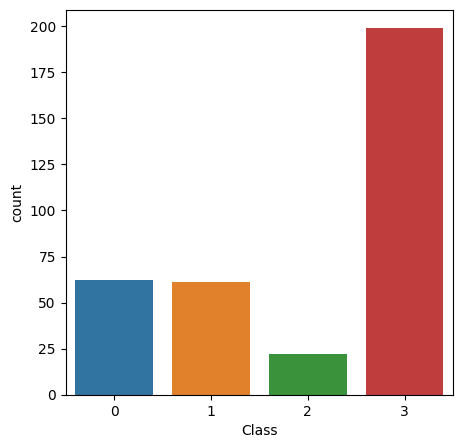

In [45]:
plt.figure(figsize=(5,5))
sns.countplot(x=E_data.Class);

In [46]:
# Generate and plot a synthetic imbalanced classification dataset
counter = Counter(E_data["Class"])
print('%s : %d' % ('Early Recurrence', counter[0]))
print('%s : %d' % ('Middle Recurrence', counter[1]))
print('%s : %d' % ('Late Recurrence', counter[2]))
print('%s : %d' % ('Non Recurrence', counter[3]))

Early Recurrence : 62
Middle Recurrence : 61
Late Recurrence : 22
Non Recurrence : 199


## GPP Conclusions and Actions

Considering the previus analysis, the following actions were taken:

1. **Remove "Sex" attribute**: The number of men record (4) is not significant to be considered in the analysis. If only men records are removed the attribute will have only one value (Women).

2. **Standardize all continuous variables**: The continuous variables are standardized to have a mean of 0 and a standard deviation of 1.

3. **Categorical attributes with int values**: The categorical attributes with int values stay as they are.

4. **Correlation between attributes**: Winter Hypoxia Score and Ragnum Hypoxia Score are highly correlated with Buffa Hypoxia Score are (0.84 and 0.72). The attribute Buffa Hypoxia Score is removed from the dataset.

5. **Target Class**: The target class is unbalanced and has 3 classes related to the recurrence of breast cancer. Where class 3 is related to the absence of recurrence and classes 1 and 2 are related to the time when the recurrence occurred. In this stage no action is taken to balance the target class. The classes 1 and 2 are grouped in class 1 mid/late recurrence.

## E-1 Dataset

In [47]:
# Merge class 1 and 2 into class 1, and replace 3 with 2
E_data['Class'] = E_data['Class'].replace([2, 3], [1,2])
E_data.value_counts('Class')

Class
2    199
1     83
0     62
dtype: int64

In [48]:
E1_data = E_data.copy()
E1_data.head()

,Cancer Type Detailed,Subtype,Diagnosis Age,Sex,Ethnicity Category,Race Category,Neoplasm Cancer Code,Aneuploidy Score,Buffa Hypoxia Score,Ragnum Hypoxia Score,Winter Hypoxia Score,Fraction Genome Altered,In PanCan Pathway Analysis,Mutation Count,Post Initial Therapy,Prior Diagnosis,Radiation Therapy,Tissue Prospective Indicator,Class
0,2,2,55,0,1,2,11,19,-21,0,-28,0.7787,1,24,0,0,0,0,1
1,1,1,50,0,1,1,5,22,5,18,20,0.7164,1,458,0,0,1,0,2
2,0,0,54,0,1,0,4,16,27,14,22,0.4163,1,62,1,0,1,0,1
3,1,2,66,0,0,2,1,3,-27,-8,-20,0.0862,1,41,0,0,1,0,2
4,1,0,36,0,1,1,9,9,17,12,4,0.6407,1,128,1,0,1,0,0


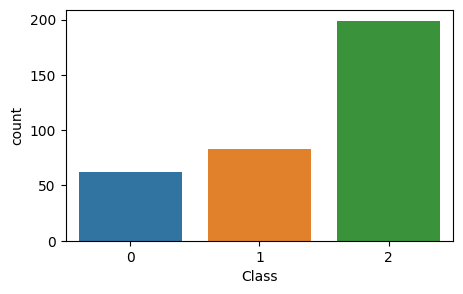

In [49]:
figura = plt.figure(figsize=(5,3))
sns.countplot(x=E1_data.Class);

In [50]:
E1_data["Class"].value_counts()

2    199
1     83
0     62
Name: Class, dtype: int64

In [51]:
counter = Counter(E1_data["Class"])
print('%s : %d' % ('Early Recurrence', counter[0]))
print('%s : %d' % ('Mid/late Recurrence', counter[1]))
print('%s : %d' % ('Non Recurrence', counter[2]))

Early Recurrence : 62
Mid/late Recurrence : 83
Non Recurrence : 199


## E-2 Dataset

In [52]:
drop_cols = ['Sex', 'Buffa Hypoxia Score']
standardize_cols = ["Diagnosis Age","Aneuploidy Score","Ragnum Hypoxia Score",
                    "Winter Hypoxia Score","Fraction Genome Altered", "Mutation Count"]
E2_data = gpp_preprocess(E1_data, drop_cols, standardize_cols)
E2_data.head()

,Cancer Type Detailed,Subtype,Diagnosis Age,Ethnicity Category,Race Category,Neoplasm Cancer Code,Aneuploidy Score,Ragnum Hypoxia Score,Winter Hypoxia Score,Fraction Genome Altered,In PanCan Pathway Analysis,Mutation Count,Post Initial Therapy,Prior Diagnosis,Radiation Therapy,Tissue Prospective Indicator,Class
0,2,2,-0.099707,1,2,11,0.917510,-0.232988,-0.786458,2.306375,1,-0.208468,0,0,0,0,1
1,1,1,-0.468189,1,1,5,1.318307,1.269528,1.531165,2.011235,1,1.568424,0,0,1,0,2
2,0,0,-0.173403,1,0,4,0.516713,0.935635,1.627732,0.589544,1,-0.052888,1,0,1,0,1
3,1,2,0.710954,0,2,1,-1.220072,-0.900773,-0.400188,-0.974270,1,-0.138866,0,0,1,0,2
4,1,0,-1.499940,1,1,9,-0.418479,0.768689,0.758624,1.652615,1,0.217331,1,0,1,0,0


## E-3 Dataset
This dataset is used in the experiment E-3. It is the dataset with GPP + Feature Selection with mRMR.

In [53]:
E3_data = mrmr_preprocess(E2_data, "Class")
E3_data.head()

100%|██████████| 10/10 [00:01<00:00,  5.53it/s]


,Post Initial Therapy,Cancer Type Detailed,Tissue Prospective Indicator,Neoplasm Cancer Code,Aneuploidy Score,Radiation Therapy,Winter Hypoxia Score,Prior Diagnosis,Mutation Count,Diagnosis Age,Class
0,0,2,0,11,0.917510,0,-0.786458,0,-0.208468,-0.099707,1
1,0,1,0,5,1.318307,1,1.531165,0,1.568424,-0.468189,2
2,1,0,0,4,0.516713,1,1.627732,0,-0.052888,-0.173403,1
3,0,1,0,1,-1.220072,1,-0.400188,0,-0.138866,0.710954,2
4,1,1,0,9,-0.418479,1,0.758624,0,0.217331,-1.499940,0


## E-4 Dataset

This dataset is used in the experiment E-4. It is the dataset with GPP + Feature Selection with mRMR + Oversample with SMOTE. We are going to do a copy of E-3 dataset to use it in E-4 and then apply the SMOTE technique to balance the target class when the experiment is executed.

In [54]:
E4_data = E3_data.copy()
E4_data.head()

,Post Initial Therapy,Cancer Type Detailed,Tissue Prospective Indicator,Neoplasm Cancer Code,Aneuploidy Score,Radiation Therapy,Winter Hypoxia Score,Prior Diagnosis,Mutation Count,Diagnosis Age,Class
0,0,2,0,11,0.917510,0,-0.786458,0,-0.208468,-0.099707,1
1,0,1,0,5,1.318307,1,1.531165,0,1.568424,-0.468189,2
2,1,0,0,4,0.516713,1,1.627732,0,-0.052888,-0.173403,1
3,0,1,0,1,-1.220072,1,-0.400188,0,-0.138866,0.710954,2
4,1,1,0,9,-0.418479,1,0.758624,0,0.217331,-1.499940,0




---



# 2 - Run Experiments



In [55]:
# Function to print the results in latex format
table_labels = ["mean_Accuracy Score","std_Accuracy Score","mean_Precision Score","std_Precision Score", "mean_Recall Score", "std_Recall Score"]
def print_latex_rows(data:pd.DataFrame, table_labels: list):
    for index, row in data.iterrows():
        print("%s & %.3f $\pm$ %.3f & %.3f $\pm$ %.3f & %.3f $\pm$ %.3f \\\\" % (index, row[table_labels[0]], row[table_labels[1]], row[table_labels[2]], row[table_labels[3]], row[table_labels[4]], row[table_labels[5]]))

## E-1 (Experiment 1)

**E-1**: Training of Logistic Regression (LR), Naive Bayes (NB), Support Vector Machine (SVM), k nearest neighbors (KNN) models using the original dataset.

Calculation of performance metrics using the original dataset, to have an initial reference point. 

In [56]:
default_params = load_params("tune_params/default_params_4C.json")

In [57]:
#E1_Results = run_experiment(E1_data, "Class","E1", default_params)
#E1_Results

## E-2 (Experiment 2)

**E-2**: Training of Logistic Regression (LR), Naive Bayes (NB), Support Vector Machine (SVM), k nearest neighbors (KNN) models using the dataset with GPP.

In [58]:
E2_Results = run_experiment(E2_data, "Class","E2", default_params, num_exp=10)
E2_Results

Running experiment: 1,

/home/diripar8/anaconda3/envs/uldev/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/diripar8/anaconda3/envs/uldev/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

2,

/home/diripar8/anaconda3/envs/uldev/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/diripar8/anaconda3/envs/uldev/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

3,

/home/diripar8/anaconda3/envs/uldev/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/diripar8/anaconda3/envs/uldev/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

4,

/home/diripar8/anaconda3/envs/uldev/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/diripar8/anaconda3/envs/uldev/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

5,

/home/diripar8/anaconda3/envs/uldev/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/diripar8/anaconda3/envs/uldev/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

6,

/home/diripar8/anaconda3/envs/uldev/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/diripar8/anaconda3/envs/uldev/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

7,

/home/diripar8/anaconda3/envs/uldev/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/diripar8/anaconda3/envs/uldev/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

8,

/home/diripar8/anaconda3/envs/uldev/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/diripar8/anaconda3/envs/uldev/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

9,

/home/diripar8/anaconda3/envs/uldev/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/diripar8/anaconda3/envs/uldev/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

10,

/home/diripar8/anaconda3/envs/uldev/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/diripar8/anaconda3/envs/uldev/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

 Done! 

,Models,mean_Accuracy (kfold),std_Accuracy (kfold),mean_Accuracy Score,std_Accuracy Score,mean_Precision Score,std_Precision Score,mean_Recall Score,std_Recall Score,mean_F1 Score,std_F1 Score
0,LR,0.824,0.010,0.806,0.052,0.920,0.039,0.987,0.013,0.952,0.022
1,NB,0.779,0.008,0.781,0.036,0.914,0.030,0.928,0.029,0.920,0.020
2,SVM,0.803,0.014,0.813,0.032,0.884,0.028,0.974,0.027,0.927,0.023
3,KNN,0.679,0.009,0.654,0.022,0.741,0.052,0.898,0.035,0.810,0.023
4,XGB,0.786,0.010,0.760,0.035,0.886,0.030,0.954,0.032,0.918,0.020


## E-3 (Experiment 3)

**E-3**: A feature selection techniques (mRMR) is applied to the dataset with GPP to select the most significant attributes for the target class. Then, the training of Logistic Regression (LR), Naive Bayes (NB), Support Vector Machine (SVM), k nearest neighbors (KNN) models is performed.

In [60]:
E3_Results = run_experiment(E3_data, "Class","E3", default_params, num_exp=10)
E3_Results

Running experiment: 1,2,3,4,5,6,7,8,9,10, Done! 

,Models,mean_Accuracy (kfold),std_Accuracy (kfold),mean_Accuracy Score,std_Accuracy Score,mean_Precision Score,std_Precision Score,mean_Recall Score,std_Recall Score,mean_F1 Score,std_F1 Score
0,LR,0.821,0.006,0.807,0.026,0.911,0.028,0.995,0.011,0.951,0.017
1,NB,0.814,0.002,0.791,0.043,0.909,0.046,0.948,0.028,0.927,0.029
2,SVM,0.797,0.006,0.819,0.038,0.895,0.044,0.988,0.013,0.939,0.025
3,KNN,0.700,0.011,0.687,0.048,0.767,0.051,0.904,0.042,0.828,0.027
4,XGB,0.759,0.008,0.759,0.028,0.920,0.038,0.956,0.034,0.937,0.019


## E-4 (Experiment 4)

**E-4**: The technique SMOTE is applied to the dataset with GPP + Feature Selection to balance the target class. Then, the training of Logistic Regression (LR), Naive Bayes (NB), Support Vector Machine (SVM), k nearest neighbors (KNN) models is performed.

In [63]:
E4_Results = run_experiment(E4_data, "Class","E4", default_params, num_exp=10)
E4_Results

Running experiment: 1,

/home/diripar8/anaconda3/envs/uldev/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/diripar8/anaconda3/envs/uldev/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

2,

/home/diripar8/anaconda3/envs/uldev/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/diripar8/anaconda3/envs/uldev/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

3,

/home/diripar8/anaconda3/envs/uldev/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/diripar8/anaconda3/envs/uldev/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

4,

/home/diripar8/anaconda3/envs/uldev/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/diripar8/anaconda3/envs/uldev/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

5,

/home/diripar8/anaconda3/envs/uldev/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/diripar8/anaconda3/envs/uldev/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

6,

/home/diripar8/anaconda3/envs/uldev/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/diripar8/anaconda3/envs/uldev/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

7,

/home/diripar8/anaconda3/envs/uldev/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/diripar8/anaconda3/envs/uldev/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

8,

/home/diripar8/anaconda3/envs/uldev/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/diripar8/anaconda3/envs/uldev/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

9,

/home/diripar8/anaconda3/envs/uldev/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/diripar8/anaconda3/envs/uldev/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

10,

/home/diripar8/anaconda3/envs/uldev/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/diripar8/anaconda3/envs/uldev/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

 Done! 

,Models,mean_Accuracy (kfold),std_Accuracy (kfold),mean_Accuracy Score,std_Accuracy Score,mean_Precision Score,std_Precision Score,mean_Recall Score,std_Recall Score,mean_F1 Score,std_F1 Score
0,LR,0.703,0.005,0.714,0.033,0.775,0.047,0.960,0.030,0.857,0.029
1,NB,0.663,0.002,0.671,0.042,0.750,0.059,0.958,0.019,0.840,0.036
2,SVM,0.745,0.004,0.748,0.045,0.771,0.071,0.970,0.027,0.858,0.052
3,KNN,0.800,0.005,0.793,0.033,0.846,0.068,0.734,0.056,0.784,0.045
4,XGB,0.837,0.006,0.825,0.029,0.833,0.074,0.876,0.027,0.852,0.044


----

# 3 - Tuning with GridSearchCV

The models are tuned using GridSearchCV to find the best parameters for each model. The parameters are defined in [tuning_parameters.yml](tune_params/tuning_parameters.yml) file.

The results of the tuning are saved in `json` files in the folder `tune_params/`.

In [25]:
tune_params = load_params("tune_params/tuning_parameters.json")

## Tuning E-1

In [26]:
#E1_tune_bests = tune_experiment(E1_data,"Class","E1",tune_params,default_params)
#file_path = "tune_params/best_4C/E1_best_params.json"
#save_tuned_params(E1_tune_bests, file_path)

## Tuning E-2

In [27]:
E2_tune_bests = tune_experiment(E2_data,"Class","E2",tune_params,default_params)
file_path = "tune_params/best_4C/E2_best_params.json"
save_tuned_params(E2_tune_bests, file_path)

Tuning hyperparameters for LR...
Fitting 10 folds for each of 168 candidates, totalling 1680 fits
Tuning hyperparameters for NB...
Fitting 10 folds for each of 1000 candidates, totalling 10000 fits
Tuning hyperparameters for SVM...
Fitting 10 folds for each of 40 candidates, totalling 400 fits
Tuning hyperparameters for KNN...
Fitting 10 folds for each of 1920 candidates, totalling 19200 fits
Tuning hyperparameters for XGB...
Fitting 10 folds for each of 12600 candidates, totalling 126000 fits
Tuned parameters saved to ...


## Tuning E-3

In [28]:
E3_tune_bests = tune_experiment(E3_data,"Class","E3",tune_params,default_params)
file_path = "tune_params/best_4C/E3_best_params.json"
save_tuned_params(E3_tune_bests, file_path)

Tuning hyperparameters for LR...
Fitting 10 folds for each of 168 candidates, totalling 1680 fits
Tuning hyperparameters for NB...
Fitting 10 folds for each of 1000 candidates, totalling 10000 fits
Tuning hyperparameters for SVM...
Fitting 10 folds for each of 40 candidates, totalling 400 fits
Tuning hyperparameters for KNN...
Fitting 10 folds for each of 1920 candidates, totalling 19200 fits
Tuning hyperparameters for XGB...
Fitting 10 folds for each of 12600 candidates, totalling 126000 fits
Tuned parameters saved to ...


## Tuning E-4

In [29]:
E4_tune_bests = tune_experiment(E4_data,"Class","E4",tune_params,default_params)
file_path = "tune_params/best_4C/E4_best_params.json"
save_tuned_params(E4_tune_bests, file_path)

Tuning hyperparameters for LR...
Fitting 10 folds for each of 168 candidates, totalling 1680 fits
Tuning hyperparameters for NB...
Fitting 10 folds for each of 1000 candidates, totalling 10000 fits
Tuning hyperparameters for SVM...
Fitting 10 folds for each of 40 candidates, totalling 400 fits
Tuning hyperparameters for KNN...
Fitting 10 folds for each of 1920 candidates, totalling 19200 fits
Tuning hyperparameters for XGB...
Fitting 10 folds for each of 12600 candidates, totalling 126000 fits
Tuned parameters saved to ...


---

# 4 - Run Experiments With Tuning Parameters

In [70]:
#E1_best_params = load_params("tune_params/best_4C/E1_best_params.json")
E2_best_params = load_params("tune_params/best_4C/E2_best_params.json")
E3_best_params = load_params("tune_params/best_4C/E3_best_params.json")
E4_best_params = load_params("tune_params/best_4C/E4_best_params.json")

## E-1 (Experiment 1)

In [31]:
#E1_Results = run_experiment(E1_data, "Class","E1", E1_best_params)
#E1_Results

## E-2 (Experiment 2)

In [71]:
E2_Results = run_experiment(E2_data, "Class","E2", E2_best_params, num_exp=10)
E2_Results

Running experiment: 1,2,3,4,5,6,7,8,9,10, Done! 

,Models,mean_Accuracy (kfold),std_Accuracy (kfold),mean_Accuracy Score,std_Accuracy Score,mean_Precision Score,std_Precision Score,mean_Recall Score,std_Recall Score,mean_F1 Score,std_F1 Score
0,LR,0.821,0.006,0.819,0.053,0.905,0.037,1.000,0.000,0.950,0.021
1,NB,0.814,0.008,0.806,0.033,0.901,0.032,0.981,0.012,0.939,0.020
2,SVM,0.819,0.010,0.800,0.030,0.895,0.032,0.993,0.014,0.941,0.017
3,KNN,0.729,0.009,0.706,0.063,0.732,0.059,0.968,0.042,0.832,0.048
4,XGB,0.822,0.007,0.810,0.022,0.895,0.045,0.988,0.013,0.938,0.026


In [72]:
print_latex_rows(E2_Results, table_labels)

0 & 0.819 $\pm$ 0.053 & 0.905 $\pm$ 0.037 & 1.000 $\pm$ 0.000 \\
1 & 0.806 $\pm$ 0.033 & 0.901 $\pm$ 0.032 & 0.981 $\pm$ 0.012 \\
2 & 0.800 $\pm$ 0.030 & 0.895 $\pm$ 0.032 & 0.993 $\pm$ 0.014 \\
3 & 0.706 $\pm$ 0.063 & 0.732 $\pm$ 0.059 & 0.968 $\pm$ 0.042 \\
4 & 0.810 $\pm$ 0.022 & 0.895 $\pm$ 0.045 & 0.988 $\pm$ 0.013 \\


## E-3 (Experiment 3)

In [73]:
E3_Results = run_experiment(E3_data, "Class","E3", E3_best_params, num_exp=10)
E3_Results

Running experiment: 1,2,3,4,5,6,7,8,9,10, Done! 

,Models,mean_Accuracy (kfold),std_Accuracy (kfold),mean_Accuracy Score,std_Accuracy Score,mean_Precision Score,std_Precision Score,mean_Recall Score,std_Recall Score,mean_F1 Score,std_F1 Score
0,LR,0.821,0.006,0.825,0.033,0.926,0.034,0.995,0.010,0.959,0.019
1,NB,0.810,0.007,0.803,0.036,0.910,0.025,0.981,0.017,0.944,0.018
2,SVM,0.800,0.007,0.816,0.034,0.911,0.036,0.995,0.010,0.951,0.020
3,KNN,0.747,0.008,0.710,0.051,0.792,0.066,0.942,0.031,0.858,0.038
4,XGB,0.796,0.008,0.797,0.051,0.898,0.050,0.997,0.010,0.944,0.030


In [74]:
print_latex_rows(E3_Results, table_labels)

0 & 0.825 $\pm$ 0.033 & 0.926 $\pm$ 0.034 & 0.995 $\pm$ 0.010 \\
1 & 0.803 $\pm$ 0.036 & 0.910 $\pm$ 0.025 & 0.981 $\pm$ 0.017 \\
2 & 0.816 $\pm$ 0.034 & 0.911 $\pm$ 0.036 & 0.995 $\pm$ 0.010 \\
3 & 0.710 $\pm$ 0.051 & 0.792 $\pm$ 0.066 & 0.942 $\pm$ 0.031 \\
4 & 0.797 $\pm$ 0.051 & 0.898 $\pm$ 0.050 & 0.997 $\pm$ 0.010 \\


## E-4 (Experiment 4)

In [75]:
E4_Results = run_experiment(E4_data, "Class","E4", E4_best_params, num_exp=10)
E4_Results

Running experiment: 1,2,3,4,5,6,7,8,9,10, Done! 

,Models,mean_Accuracy (kfold),std_Accuracy (kfold),mean_Accuracy Score,std_Accuracy Score,mean_Precision Score,std_Precision Score,mean_Recall Score,std_Recall Score,mean_F1 Score,std_F1 Score
0,LR,0.699,0.004,0.713,0.035,0.770,0.038,0.940,0.042,0.845,0.029
1,NB,0.682,0.003,0.680,0.040,0.752,0.061,0.945,0.022,0.836,0.037
2,SVM,0.865,0.005,0.865,0.035,0.870,0.056,0.864,0.045,0.865,0.034
3,KNN,0.853,0.007,0.864,0.039,0.899,0.054,0.811,0.060,0.852,0.051
4,XGB,0.850,0.008,0.833,0.031,0.880,0.047,0.896,0.054,0.886,0.035


In [76]:
print_latex_rows(E4_Results, table_labels)

0 & 0.713 $\pm$ 0.035 & 0.770 $\pm$ 0.038 & 0.940 $\pm$ 0.042 \\
1 & 0.680 $\pm$ 0.040 & 0.752 $\pm$ 0.061 & 0.945 $\pm$ 0.022 \\
2 & 0.865 $\pm$ 0.035 & 0.870 $\pm$ 0.056 & 0.864 $\pm$ 0.045 \\
3 & 0.864 $\pm$ 0.039 & 0.899 $\pm$ 0.054 & 0.811 $\pm$ 0.060 \\
4 & 0.833 $\pm$ 0.031 & 0.880 $\pm$ 0.047 & 0.896 $\pm$ 0.054 \\


In [35]:
#%%shell
#jupyter nbconvert --to html /content/Projeto_DS.ipynb